<a href="https://colab.research.google.com/github/lugsantistebanji/WCS-IA/blob/main/WCS_IA_Quetes_Scraping_Crawling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CRAWLING

## Introduction : qu'est-ce que le crawling ?

Le crawling consiste à parcourir (en la "scrapant") une page web pour en recueillir les liens qu'elle contient, puis aller scraper l'ensemble de ces liens. Nous pourrions continuer ce crawling en allant ensuite dans l'ensemble des liens contenus dans les pages référencées, etc...

## Les grandes étapes

Le crawling s'effectue donc en deux étapes principales :

- Tout d'abord il faut faire du scraping sur une première page, et stocker les liens (URL) qui nous intéressent ;

- Ensuite, il faudra faire du scraping sur tous ces liens, et stocker les résultats.

La difficulté sera de bien stocker tous les éléments intermédiaires (comme les URL par exemple, et les différents codes HTML ou "soupes"). Il n'y a pas de règles officielles pour cela. Certains préféreront les dictionnaires imbriqués (le format JSON), d'autres une vision tabulaire (avec des DataFrames). Utilisez la méthode avec laquelle vous êtes le plus à l'aise. Nous allons ici montrer un exemple en utilisant des DataFrames.

## Application technique

Prenons un exemple : nous souhaitons connaitre la durée moyenne des films de Christopher Nolan. Pour cela nous allons récupérer la liste des films de ce réalisateur, puis pour chacun des films nous irons sur la page correspondante pour obtenir la durée du film. A la fin, nous pourrons calculer la moyenne.

## Récupération des URL

Nous allons récupérer le code HTML de l'encadré correspondant aux films dont Christopher Nolan est réalisateur. Pour cela nous allons requêter la page Allociné, puis nous allons chercher le bloc correspondant à ces films. En effet nous voulons éviter de récupérer tous les autres liens présents dans cette page (qui pointent vers la page d'accueil, vers les contacts, etc...).

In [85]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import re
import time

In [3]:
url_base = "https://www.allocine.fr"
url = url_base + "/personne/fichepersonne-30367/filmographie/"
navigator = 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1)'
html = requests.get(url, headers={'User-Agent': navigator})
soup = BeautifulSoup(html.text, 'html.parser')

In [5]:
print(url)

https://www.allocine.fr/personne/fichepersonne-30367/filmographie/


In [10]:
# Nous filtrons maintenant uniquement sur les films dont l'artiste est le réalisateur :

soup_director = soup.find('section', {"id" : "direction"})

In [15]:
# Puis nous cherchons tous les liens contenus dans cet encadré :

links = soup_director.find_all('a')

In [13]:
links[0]

<a class="responsive-table-link" href="/film/fichefilm_gen_cfilm=244186.html" title="The Prisoner">The Prisoner</a>

__Title and Href of movies__


In [20]:
movies = [{'title': link['title'], 'href': link['href']} for link in links]

[{'title': 'The Prisoner', 'href': '/film/fichefilm_gen_cfilm=244186.html'}, {'title': 'The Odyssey', 'href': '/film/fichefilm_gen_cfilm=1000013045.html'}, {'title': 'Oppenheimer', 'href': '/film/fichefilm_gen_cfilm=296168.html'}, {'title': 'Tenet', 'href': '/film/fichefilm_gen_cfilm=251315.html'}, {'title': 'Dunkerque', 'href': '/film/fichefilm_gen_cfilm=240850.html'}, {'title': 'Quay', 'href': '/film/fichefilm_gen_cfilm=239766.html'}, {'title': 'Interstellar', 'href': '/film/fichefilm_gen_cfilm=114782.html'}, {'title': 'The Dark Knight Rises', 'href': '/film/fichefilm_gen_cfilm=132874.html'}, {'title': 'Inception', 'href': '/film/fichefilm_gen_cfilm=143692.html'}, {'title': 'The Dark Knight, Le Chevalier Noir', 'href': '/film/fichefilm_gen_cfilm=115362.html'}, {'title': 'Le Prestige', 'href': '/film/fichefilm_gen_cfilm=108998.html'}, {'title': 'Cinema 16 : European short films', 'href': '/film/fichefilm_gen_cfilm=218495.html'}, {'title': 'Batman Begins', 'href': '/film/fichefilm_gen_

---
---

## Challenge



Essaye de calculer l'âge moyen des acteurs et actrices dans le film Interstellar.

---

__Href of actors__

In [57]:
for movie in movies:
    url_movie = url_base + movie['href']
    html = requests.get(url_movie, headers={'User-Agent': navigator})
    soup = BeautifulSoup(html.text, 'html.parser')
    actors_link = soup.find(title=re.compile("Casting complet et équipe technique"))
    movie['href_casting'] = actors_link['href'] if actors_link is not None else None

---

__Actors name and href__

In [87]:
for movie in movies:
    if movie['href_casting']:
        url_casting = url_base + movie['href_casting']
        html = requests.get(url_casting, headers={'User-Agent': navigator})
        soup = BeautifulSoup(html.text, 'html.parser')
        actors = soup.find('section', {'class': 'casting-actor'}).find_all('a', {'class': 'meta-title-link'})
        movie['actors'] = [{'name': actor.string, 'href':actor['href']} for actor in actors]
    else:
        movie['actors'] = []
    time.sleep(2)

---

__Actors age__

In [91]:
for movie in movies:
    time.sleep(3)
    for actor in movie['actors']:
        url_actor = url_base + actor['href']
        html = requests.get(url_actor, headers={'User-Agent': navigator})
        soup = BeautifulSoup(html.text, 'html.parser')
        age_bloc = soup.find('div', {'class': 'person-card-overview'}).find(string=re.compile('Age'))
        age = None
        if age_bloc:
            age = age_bloc.parent.parent.div.strong.string
        actor['age'] = int(age) if age is not None else None
        time.sleep(2)

---

__Movies a DataFrame__

In [92]:
df = pd.DataFrame(movies)

In [93]:
df.head()

,title,href,href_casting,actors
0,The Prisoner,/film/fichefilm_gen_cfilm=244186.html,None,[]
1,The Odyssey,/film/fichefilm_gen_cfilm=1000013045.html,/film/fichefilm-1000013045/casting/,"[{'name': 'Tom Holland', 'href': '/personne/fi..."
2,Oppenheimer,/film/fichefilm_gen_cfilm=296168.html,/film/fichefilm-296168/casting/,"[{'name': 'Cillian Murphy', 'href': '/personne..."
3,Tenet,/film/fichefilm_gen_cfilm=251315.html,/film/fichefilm-251315/casting/,"[{'name': 'John David Washington', 'href': '/p..."
4,Dunkerque,/film/fichefilm_gen_cfilm=240850.html,/film/fichefilm-240850/casting/,"[{'name': 'Fionn Whitehead', 'href': '/personn..."


---

__Average age of actors by movie__

In [108]:
def avg_age_actors(actors_list: list) -> float:
    total = 0
    count = 0
    for actor in actors_list:
        if actor['age']:
            total += actor['age']
            count += 1

    return round(total/count, 1) if count > 0 else None

In [113]:
df['mean_age_actors'] = df['actors'].apply(avg_age_actors)

In [114]:
df.head()

,title,href,href_casting,actors,mean_age_actors
0,The Prisoner,/film/fichefilm_gen_cfilm=244186.html,None,[],NaN
1,The Odyssey,/film/fichefilm_gen_cfilm=1000013045.html,/film/fichefilm-1000013045/casting/,"[{'name': 'Tom Holland', 'href': '/personne/fi...",41.0
2,Oppenheimer,/film/fichefilm_gen_cfilm=296168.html,/film/fichefilm-296168/casting/,"[{'name': 'Cillian Murphy', 'href': '/personne...",46.1
3,Tenet,/film/fichefilm_gen_cfilm=251315.html,/film/fichefilm-251315/casting/,"[{'name': 'John David Washington', 'href': '/p...",44.1
4,Dunkerque,/film/fichefilm_gen_cfilm=240850.html,/film/fichefilm-240850/casting/,"[{'name': 'Fionn Whitehead', 'href': '/personn...",42.0


<Axes: title={'center': 'Mean age of actors by movie'}, xlabel='Movie', ylabel='Age'>

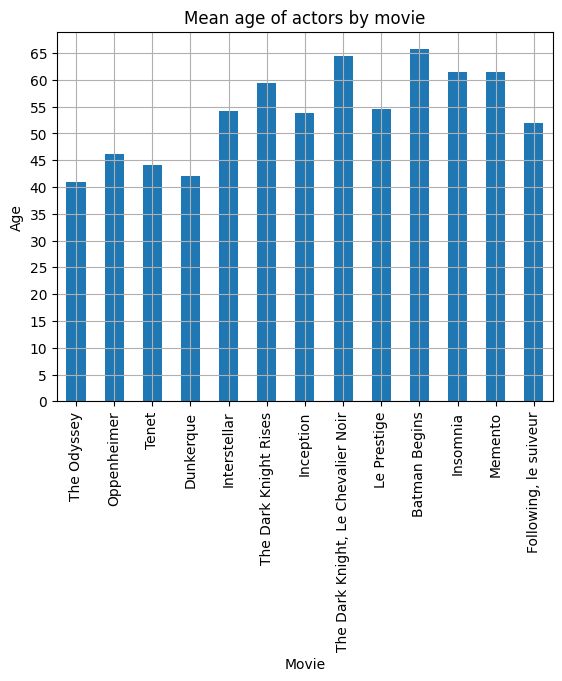

In [125]:
df.loc[~df['mean_age_actors'].isna()].plot.bar(x='title', y='mean_age_actors', legend=False, xlabel='Movie', ylabel='Age', title='Mean age of actors by movie', yticks=range(0, 70, 5), grid=True)